In [10]:
import os
import sys
import pandas as pd

notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)

from folktables import ACSDataSource, ACSEmployment
from src.train_fair import FairLogisticRegression
from src.data_utils import joint_distribution
from src.analyze_metric_sensitivity import analyze_metric_bias_sensitivity
import numpy as np
import matplotlib.pyplot as plt

In [11]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["AL"], download=True)
features, label, group = ACSEmployment.df_to_numpy(acs_data)
group = group-1

In [12]:
prop = int(0.8 * label.shape[0])
perm = np.random.choice(label.shape[0], size=(label.shape[0],), replace=False)

X_train, y_train, A_train = features[:-prop], label[:-prop], group[perm][:-prop]
X_test, y_test, A_test = features[perm][-prop:], label[perm][-prop:], group[perm][-prop:]

In [13]:
FairLR = FairLogisticRegression(fairness_constraint="FNR")

In [14]:
FairLR.fit(X_train,y_train, A_train)

The grid has 7 dimensions. It is not recommended to use more than 4, otherwise a prohibitively large grid size is required to explore the space thoroughly. For such cases consider using ExponentiatedGradient from the fairlearn.reductions module.
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increas

In [15]:
test_df = {"Y": y_test.astype(int),"P":FairLR.predict(X_test), "A":A_test.astype(int)}
test_df = pd.DataFrame(test_df)

joint_dist = joint_distribution(test_df,variables=list(test_df.columns))
print(joint_dist)

   Y  P  A      prob
0  0  0  0  0.366172
1  0  0  1  0.122358
2  0  1  0  0.083653
3  0  1  1  0.019161
4  1  0  0  0.087594
5  1  0  1  0.032164
6  1  1  0  0.240474
7  1  1  1  0.048423


In [16]:
analyze_metric_bias_sensitivity(joint_dist,metric="FNR",bias="selection",sensitivity_parameter_values=0.03)

(0.021421185670976863, 0.2987723987459874, True, True)

## Recreating Plots for the Folktables Dataset

In [54]:
import seaborn as sns

sns.set_theme()
sns.set_style("whitegrid")

def get_fig_details(bias):
    
    if bias == "proxy_y":
        return r"$P(Y_P \neq Y)$", "Proxy label bias"
    
    if bias == "selection":
        return r"$P(S=0)$", "Selection Bias"
    
    if bias == "ecp":
        return r"$P(Y(1) \neq Y(0))$", "Extra Classificatory Decisions"

In [55]:
colors = sns.color_palette(n_colors=5)
rearrange_index = [0,3,1,4,2]
colors = [colors[i] for i in rearrange_index]

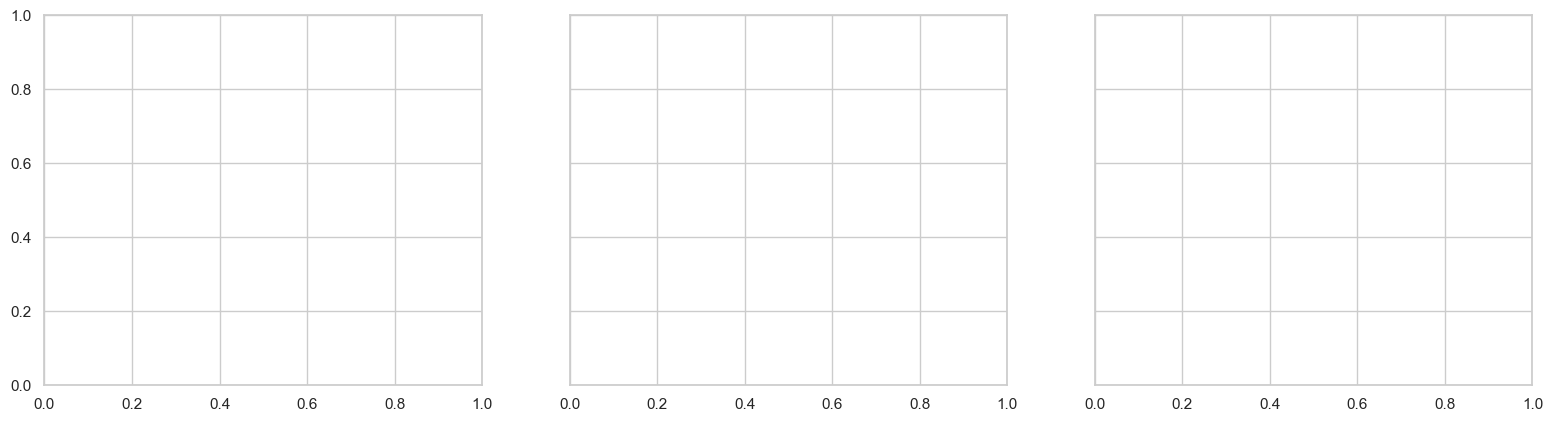

In [59]:
sensitivity_param_range = [0,0.03,0.05,0.1]

bias_list = ["selection","proxy_y","ecp"]
metric_list = ["FNR","FPR","PPP","NPP","DP"]

# bias_list = ["selection"]
# metric_list = ["FPR"]

metric_dict = {"FPR":"False Positive Rate Parity",
                         "FNR":"False Negative Rate Parity",
                         "NPP":"Negative Predictive Parity",
                         "PPP": "Positive Predictive Parity",
                         "DP": "Demograpic Parity"}

fig,axes = plt.subplots(1, 3,sharey=True,figsize= (3*6.4,4.8 ))

In [60]:
lines = []
handles = []

for i,metric in enumerate(metric_list):

    FairLR = FairLogisticRegression(fairness_constraint=metric,grid_size=4)
    FairLR.fit(X_train,y_train, A_train)

    test_df = {"Y": y_test.astype(int),"P":FairLR.predict(X_test), "A":A_test.astype(int)}
    test_df = pd.DataFrame(test_df)

    joint_dist = joint_distribution(test_df,variables=list(test_df.columns))
    
    for j,bias in enumerate(bias_list):

        y_lower,y_upper = [],[]

        for param_value in sensitivity_param_range:
            print(param_value)
            sensitivity_result = analyze_metric_bias_sensitivity(joint_dist,
                                                                metric=metric,
                                                                bias=bias,
                                                                sensitivity_parameter_values=param_value)
            y_lower.append(sensitivity_result[0])
            y_upper.append(sensitivity_result[1])

        line, = axes[j].plot(sensitivity_param_range, y_upper, ls='--', marker='o', alpha=.6,color= colors[i])

        axes[j].plot(sensitivity_param_range, y_lower, ls='--', marker='o', alpha=.6,color= colors[i])

        axes[j].fill_between(sensitivity_param_range,
                    y1=y_lower,y2=y_upper, alpha=.1,color= colors[i])

        x_label,bias_name = get_fig_details(bias)
        axes[j].set_xlabel(x_label)
        axes[j].set_title("("+chr(97+i) +") " + bias_name)

        if j ==0:
            lines.append(line)
            handles.append(metric_dict[metric])

axes[0].legend(lines,handles)

The grid has 7 dimensions. It is not recommended to use more than 4, otherwise a prohibitively large grid size is required to explore the space thoroughly. For such cases consider using ExponentiatedGradient from the fairlearn.reductions module.
Generating a grid with 4 grid points. It is recommended to use at least 128 grid points. Please consider increasing grid_size.


/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

0
0.03
0.05
0.1
0
0.03
0.05
0.1
0
0.03
0.05
0.1


The grid has 7 dimensions. It is not recommended to use more than 4, otherwise a prohibitively large grid size is required to explore the space thoroughly. For such cases consider using ExponentiatedGradient from the fairlearn.reductions module.
Generating a grid with 4 grid points. It is recommended to use at least 128 grid points. Please consider increasing grid_size.
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/sklearn/linear_model/_

0
0.03
0.05
0.1
0
0.03
0.05
0.1
0
0.03
0.05
0.1


The grid has 7 dimensions. It is not recommended to use more than 4, otherwise a prohibitively large grid size is required to explore the space thoroughly. For such cases consider using ExponentiatedGradient from the fairlearn.reductions module.
Generating a grid with 4 grid points. It is recommended to use at least 128 grid points. Please consider increasing grid_size.
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/sklearn/linear_model/_

0
0.03
0.05
0.1
0
0.03
0.05
0.1
0
0.03
0.05
0.1


The grid has 7 dimensions. It is not recommended to use more than 4, otherwise a prohibitively large grid size is required to explore the space thoroughly. For such cases consider using ExponentiatedGradient from the fairlearn.reductions module.
Generating a grid with 4 grid points. It is recommended to use at least 128 grid points. Please consider increasing grid_size.
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/sklearn/linear_model/_

0
0.03
0.05
0.1
0
0.03
0.05
0.1
0
0.03
0.05
0.1


The grid has 7 dimensions. It is not recommended to use more than 4, otherwise a prohibitively large grid size is required to explore the space thoroughly. For such cases consider using ExponentiatedGradient from the fairlearn.reductions module.
Generating a grid with 4 grid points. It is recommended to use at least 128 grid points. Please consider increasing grid_size.
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jake/miniconda3/envs/test_fair/lib/python3.10/site-packages/sklearn/linear_model/_

0
0.03
0.05
0.1
0
0.03
0.05
0.1
0
0.03
0.05
0.1


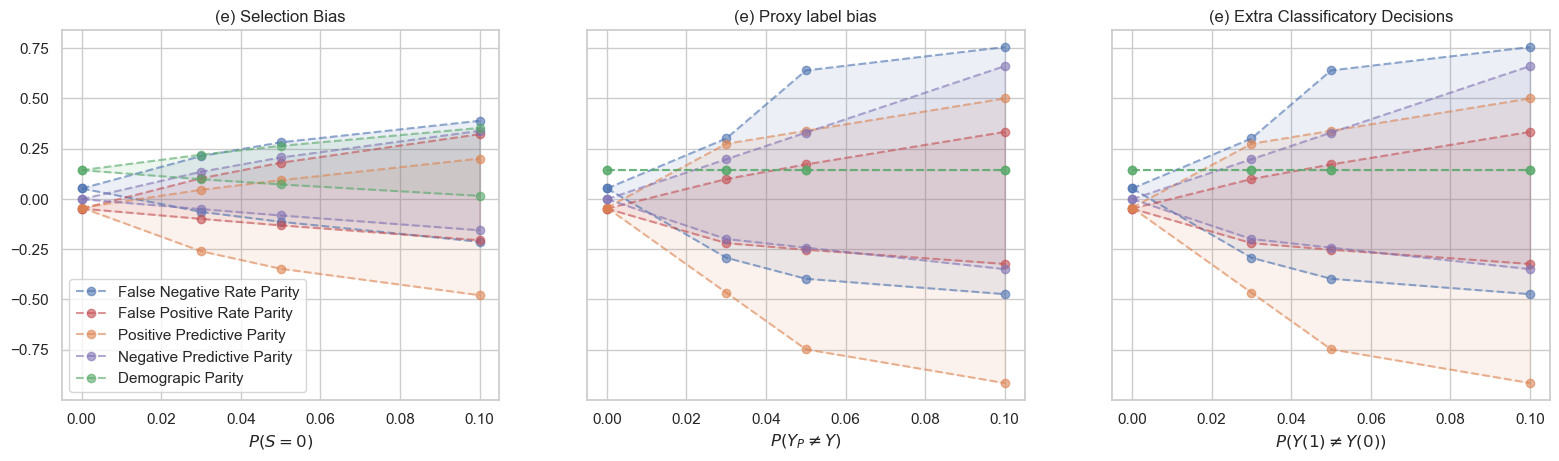

In [61]:
fig